In [1]:
import sys
sys.path.append('..')
import torch
import os
import torch.nn as nn
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from models.CycleGAN import *
from datasets.UnalignedDataset import UnalignedDataset
from utils.utils import ImageBuffer, set_requires_grad, tensor_to_image, save_cyclegan_model, get_activation, get_norm_module

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
class ContentEncoder(nn.Module):
    
    def __init__(self, num_channels, num_blocks, content_dim, norm_type="instance", pad_type="reflection"):
        super(ContentEncoder, self).__init__()
        
        self.conv1 = ConvNormRelu(in_channels=num_channels, out_channels=64,
                                  kernel_size=7, padding=(3, pad_type), leaky=False, norm=norm_type)
        self.conv2 = ConvNormRelu(in_channels=64, out_channels=128, 
                                  kernel_size=4, padding=(1, pad_type), stride=2, leaky=False, norm=norm_type)
        self.conv3 = ConvNormRelu(in_channels=128, out_channels=256, 
                                 kernel_size=4, padding=(1, pad_type), stride=2, leaky=False, norm=norm_type)
        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(ResBlock(in_planes=content_dim, kernel_size=3, padding=(1, pad_type), norm=norm_type))
    
    def forward(self, inputs):
        out = self.conv1(inputs)
        out = self.conv2(out)
        out = self.conv3(out)
        for block in self.blocks:
            out = block(out)
        return out

In [3]:
class StyleEncoder(nn.Module):
    
    def __init__(self, num_channels, style_dims, norm_type="instance", pad_type="reflection"):
        super(StyleEncoder, self).__init__()
        
        self.conv1 = ConvNormRelu(in_channels=num_channels, out_channels=64,
                                  kernel_size=7, padding=(3, pad_type), leaky=False, norm=norm_type)
        
        self.convs = nn.ModuleList()
        dims = 64
        prev_dims = 0
        n_convs = 4
        
        for _ in range(n_convs):
            prev_dims = dims
            dims = min(dims * 2, 256)
            
            self.convs.append(ConvNormRelu(in_channels=prev_dims, out_channels=dims, 
                                  kernel_size=4, padding=(1, pad_type), stride=2, leaky=False, norm=norm_type))
        
        self.conv_fc = nn.Conv2d(dims, style_dims, kernel_size=1, stride=1, padding=0)  
            
    def forward(self, inputs):
        out = self.conv1(inputs)
        for conv in self.convs:
            out = conv(out)
            
        #Fastest version of Global Average Pooling
        out = torch.mean(out.view(out.size(0), out.size(1), -1), dim=2)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = self.conv_fc(out)
        return out.view(out.size(0), -1)

In [4]:
#Nvidia implementation
class AdaptiveInstanceNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(AdaptiveInstanceNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        # weight and bias are dynamically assigned
        self.weight = None
        self.bias = None
        # just dummy buffers, not used
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        assert self.weight is not None and self.bias is not None, "Please assign weight and bias before calling AdaIN!"
        b, c = x.size(0), x.size(1)
        running_mean = self.running_mean.repeat(b)
        running_var = self.running_var.repeat(b)

        # Apply instance norm
        x_reshaped = x.contiguous().view(1, b * c, *x.size()[2:])

        out = F.batch_norm(
            x_reshaped, running_mean, running_var, self.weight, self.bias,
            True, self.momentum, self.eps)

        return out.view(b, c, *x.size()[2:])

    def __repr__(self):
        return self.__class__.__name__ + '(' + str(self.num_features) + ')'

In [5]:
class Decoder(nn.Module):
    
    def __init__(self, in_channels, norm_type="adain", pad_type="reflection"):
        super(Decoder, self).__init__()
        
        self.blocks = nn.ModuleList()
        n_blocks = 4
        for _ in range(n_blocks):
            self.blocks.append(ResBlock(in_planes=in_channels, kernel_size=3,
                                        padding=(1, pad_type), norm=norm_type))
        n_blocks = 2
        self.upsample_blocks = nn.ModuleList()
        prev_dims = 0
        dims = 256
        for _ in range(n_blocks):
            prev_dims = dims
            dims = dims // 2
            self.upsample_blocks.append(nn.Upsample(scale_factor=2))
            self.upsample_blocks.append(ConvNormRelu(in_channels=prev_dims, out_channels=dims,
                                                     kernel_size=5, padding=(2, pad_type), stride=1, norm="ln"))
            
        #self.last_layer = ConvNormRelu(in_channels=dims, out_channels=3, kernel_size=7,
                                      #padding=(3, pad_type), stride=1, norm=None)
        self.last_layer = nn.Conv2d(in_channels=dims, out_channels=3, kernel_size=7, padding=3, stride=1)
        
    def forward(self, inputs):
        out = inputs
        for block in self.blocks:
            out = block(out)
        for block in self.upsample_blocks:
            out = block(out)
        return F.tanh(self.last_layer(out))

In [6]:
class LinearNormAct(nn.Module):
    
    def __init__(self, in_channels, out_channels, norm='batch', activation="relu"):
        super(LinearNormAct, self).__init__()
        
        self.fc = nn.Linear(in_channels, out_channels)
        self.norm = get_norm_module(norm)(out_channels)
        self.activation = get_activation(activation)
    
    def forward(self, inputs):
        out = self.fc(inputs)
        out = self.norm(out)
        if self.activation is not None:
            return self.activation(out)
        else:
            return out

In [7]:
class MLP(nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_dim, num_blocks, norm_type="none"):
        super(MLP, self).__init__()
        
        self.fc1 = LinearNormAct(in_channels=in_channels, out_channels=hidden_dim, norm=norm_type)
        
        self.blocks = nn.ModuleList()
        for _ in range(num_blocks - 2):
            self.blocks.append(LinearNormAct(in_channels=hidden_dim, out_channels=hidden_dim, norm=norm_type))
        
        self.last_fc = LinearNormAct(in_channels=hidden_dim, out_channels=out_channels, norm=norm_type, activation="none")
        
    def forward(self, inputs):
        
        out = self.fc1(inputs)
        for block in self.blocks:
            out = block(out)
        return self.last_fc(out)
    

In [8]:
class MUnitAutoencoder(nn.Module):
    
    def __init__(self, in_channels, mlp_hidden_dim, mlp_num_blocks, enc_style_dims, enc_cont_num_blocks,
                 norm_type_cont, pad_type_cont, norm_type_style, pad_type_style, norm_type_decoder, pad_type_decoder,
                 norm_type_mlp, enc_cont_dim=256):
        super(MUnitAutoencoder, self).__init__()
        
        
        self.enc_cont = ContentEncoder(num_channels=in_channels, num_blocks=enc_cont_num_blocks, content_dim=enc_cont_dim,
                                       norm_type=norm_type_cont, pad_type=pad_type_cont)
        self.enc_style = StyleEncoder(num_channels=in_channels, style_dims=enc_style_dims, norm_type=norm_type_style,
                                      pad_type=pad_type_style)
        
        self.decoder = Decoder(in_channels=enc_cont_dim, norm_type=norm_type_decoder, pad_type=pad_type_decoder)
        self.mlp = MLP(in_channels=enc_style_dims, out_channels=self.get_num_adain_params(self.decoder),
                       hidden_dim=mlp_hidden_dim, num_blocks=mlp_num_blocks, norm_type=norm_type_mlp)
        
    
    
    
    def encode(self, inputs):
        enc_cont = self.enc_cont(inputs)
        enc_style = self.enc_style(inputs)
        return enc_cont, enc_style
    
    def decode(self, enc_cont, enc_style):
        features = self.mlp(enc_style)
        self.assign_adain_params(features, self.decoder)
        return self.decoder(enc_cont)
    
    def forward(self, inputs):
        enc_cont, enc_style = self.encode(inputs)
        rec_inputs = self.decode(enc_cont, enc_style)
        return rec_inputs
    
    #Nvidia
    def assign_adain_params(self, adain_params, model):
        # assign the adain_params to the AdaIN layers in model
        for m in model.modules():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                mean = adain_params[:, :m.num_features]
                std = adain_params[:, m.num_features:2*m.num_features]
                m.bias = mean.contiguous().view(-1)
                m.weight = std.contiguous().view(-1)
                if adain_params.size(1) > 2*m.num_features:
                    adain_params = adain_params[:, 2*m.num_features:]
    
    #Nvidia
    def get_num_adain_params(self, model):
        # return the number of AdaIN parameters needed by the model
        num_adain_params = 0
        for m in model.modules():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                num_adain_params += 2*m.num_features
        return num_adain_params

In [9]:
class MSDiscriminator(nn.Module):
    
    def __init__(self, in_channels, num_scales):
        super(MSDiscriminator, self).__init__()
        
        self.discrs = nn.ModuleList()
        self.in_channels = in_channels
        self.num_scales = num_scales
        for _ in range(self.num_scales):
            self.discrs.append(self.create_discr(self.in_channels))
        
        self.downsample = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, count_include_pad=False)
        
        
    
    def create_discr(self, in_channels):
        prev_dims = 0
        dims = 64
        self.discr = []
        n_blocks = 3
        
        self.discr += [ConvNormRelu(in_channels=in_channels, out_channels=dims, 
                                  kernel_size=4, padding=(1, "reflection"), stride=2, leaky=True, norm='none')]
        
        for _ in range(n_blocks):
            prev_dims = dims
            dims = dims * 2
            self.discr += [ConvNormRelu(in_channels=prev_dims, out_channels=dims, 
                                  kernel_size=4, padding=(1, "reflection"), stride=2, leaky=True, norm='none')]
        
        self.discr += [nn.Conv2d(dims, out_channels=1, kernel_size=1, padding=0)]
        return nn.Sequential(*self.discr)
        
    
    def forward(self, inputs):
        outputs = []
        for discr in self.discrs:
            outputs.append(discr(inputs))
            inputs = self.downsample(inputs)
        return outputs
    
    def discr_loss(self, real, fake):
        outputs_real = self.forward(real)
        outputs_fake = self.forward(fake.detach())
        loss_fake = 0
        loss_real = 0
        #print(outputs_real)
        #print(outputs_fake)
        for i in range(self.num_scales):
            loss_fake += calc_mse_loss(outputs_fake[i], 0.0)
            loss_real += calc_mse_loss(outputs_real[i], 1.0)
        
        print("Loss_D Fake: ", loss_fake)
        print("Loss_D Real: ", loss_real)
        loss = loss_fake + loss_real
        #print("One of discriminators loss: ", loss)
        
        return loss
    
    
    def gen_loss(self, fake):
        loss = 0
        outputs_fake = self.forward(fake)
        for i in range(self.num_scales):
            loss += calc_mse_loss(outputs_fake[i], 1.0) 
        return loss

In [10]:
class MUnit(nn.Module):
    
    
    def __init__(self, in_channels, mlp_hidden_dim, mlp_num_blocks, d_num_scales, enc_style_dims,
                 enc_cont_num_blocks, norm_type_cont, pad_type_cont, norm_type_style, pad_type_style, norm_type_decoder, pad_type_decoder,
                 norm_type_mlp, enc_cont_dim=256):
              
                 
        super(MUnit, self).__init__()
        
        
        self.G1 = MUnitAutoencoder(in_channels=in_channels, mlp_hidden_dim=mlp_hidden_dim, mlp_num_blocks=mlp_num_blocks,
                                   enc_style_dims=enc_style_dims, enc_cont_num_blocks=enc_cont_num_blocks, norm_type_cont=norm_type_cont,
                                   pad_type_cont=pad_type_cont, norm_type_style=norm_type_style, pad_type_style=pad_type_style,
                                   norm_type_decoder=norm_type_decoder, pad_type_decoder=pad_type_decoder, norm_type_mlp=norm_type_mlp,
                                   enc_cont_dim=enc_cont_dim)
        
        self.G2 = MUnitAutoencoder(in_channels=in_channels, mlp_hidden_dim=mlp_hidden_dim, mlp_num_blocks=mlp_num_blocks,
                                   enc_style_dims=enc_style_dims, enc_cont_num_blocks=enc_cont_num_blocks, norm_type_cont=norm_type_cont,
                                   pad_type_cont=pad_type_cont, norm_type_style=norm_type_style, pad_type_style=pad_type_style,
                                   norm_type_decoder=norm_type_decoder, pad_type_decoder=pad_type_decoder, norm_type_mlp=norm_type_mlp,
                                   enc_cont_dim=enc_cont_dim)
        
        self.D1 = MSDiscriminator(in_channels, num_scales=d_num_scales)
        
        self.D2 = MSDiscriminator(in_channels, num_scales=d_num_scales)
        
    
    
    def forward(self, domain_A, domain_B):
        
        cont_A, style_A = self.G1.encode(domain_A)
        cont_B, style_B = self.G2.encode(domain_B)
        
        fake_style_B = torch.randn(*style_B.shape).cuda()
        fake_style_A = torch.randn(*style_A.shape).cuda()
        
        fake_A = self.G1.decode(cont_B, fake_style_A)
        fake_B = self.G2.decode(cont_A, fake_style_B)
        
        return fake_A, fake_B
        
    def backward_Gs(self, domain_A, domain_B):
        
        
        cont_A, style_A = self.G1.encode(domain_A)
        cont_B, style_B = self.G2.encode(domain_B)
        
        
        fake_style_B = torch.randn((*style_B.shape), requires_grad=True).cuda()
        fake_style_A = torch.randn((*style_A.shape), requires_grad=True).cuda()
        
        fake_A = self.G1.decode(cont_B, fake_style_A)
        fake_B = self.G2.decode(cont_A, fake_style_B)
        
        #Reconstructed images
        rec_img_A = self.G1.decode(cont_A, style_A)
        rec_img_B = self.G2.decode(cont_B, style_B)
        
        
        #Reconstructed latent contents and styles
        rec_cont_A, rec_fake_style_B = self.G2.encode(fake_B)
        rec_cont_B, rec_fake_style_A = self.G1.encode(fake_A)
        
        #Loss of reconstructed images
        img_rec_loss_A = F.l1_loss(rec_img_A, domain_A)
        img_rec_loss_B = F.l1_loss(rec_img_B, domain_B)
        print("img_rec_loss: ", img_rec_loss_A, img_rec_loss_B)
        
        #Loss of reconstructed latent content and styles
        #cont_loss_A = F.l1_loss(rec_cont_A, cont_A)
        cont_loss_A = torch.mean(torch.abs(rec_cont_A - cont_A))
        #cont_loss_B = F.l1_loss(rec_cont_B, cont_B)
        cont_loss_B = torch.mean(torch.abs(rec_cont_B - cont_B))
        print("cont_loss: ", cont_loss_A, cont_loss_B)
        
        #style_loss_A = F.l1_loss(rec_fake_style_A, fake_style_A)
        style_loss_A = torch.mean(torch.abs(rec_fake_style_A - fake_style_A))
        #style_loss_B = F.l1_loss(rec_fake_style_B, fake_style_B)
        style_loss_B = torch.mean(torch.abs(rec_fake_style_B - fake_style_B))
        print("style_loss: ", style_loss_A, style_loss_B)
        
        #Adversarial loss of generated pics
        adv_loss_A = self.D2.gen_loss(fake_B)
        adv_loss_B = self.D1.gen_loss(fake_A)
        print("Adv loss: ", adv_loss_A, adv_loss_B)
        
        
        loss = 10 * (img_rec_loss_A + img_rec_loss_B) + (adv_loss_A + adv_loss_B) + \
               (cont_loss_A + cont_loss_B) + (style_loss_A + style_loss_B)
        print("Loss: ", loss)
        loss.backward()
        
        return loss
    
    def backward_Ds(self, real_A, fake_A, real_B, fake_B):
        loss_D1 = self.D1.discr_loss(real_A, fake_A)
        loss_D2 = self.D2.discr_loss(real_B, fake_B)
        #print("loss D1 and D2: ", loss_D1, loss_D2)
        loss = loss_D1 + loss_D2
        #print("loss D: ", loss)
        loss.backward()
        
        return loss
        

In [11]:
def init_weights_normal(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.normal_(m.bias, 0.0)
        
def init_kaiming_normal(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.normal_(m.bias, 0.0)

In [12]:
transform = transforms.Compose([transforms.Resize((256, 256), Image.BICUBIC),
                                transforms.RandomCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [13]:
train_dataset = UnalignedDataset('/home/dpakhom1/Cycle_gan_pytorch/datasets/people2anime/',
                              ["trainA", "anime-faces"], limit=500, transform=transform)
val_dataset = UnalignedDataset('/home/dpakhom1/Cycle_gan_pytorch/datasets/people2anime/',
                              ["valA", "anime-faces"], transform=transform)

In [14]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1, num_workers=2)

<IPython.core.display.Javascript object>


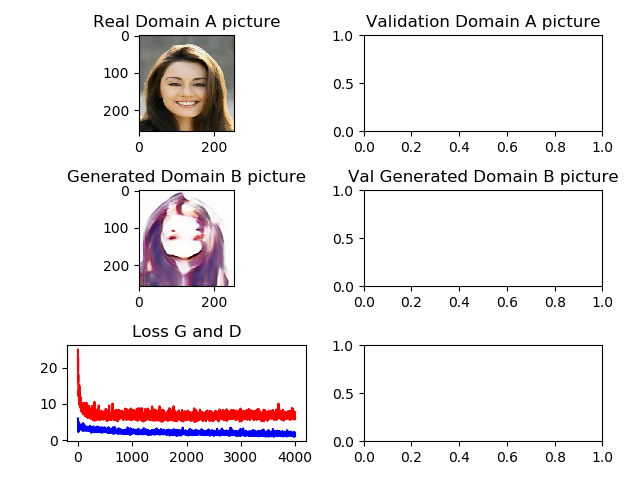

In [15]:
%matplotlib notebook
f, (real_pics, gen_pics, loss_axis) = plt.subplots(3, 2)
real_pics[0].set_title("Real Domain A picture")
gen_pics[0].set_title("Generated Domain B picture")
loss_axis[0].set_title("Loss G and D")
real_pics[1].set_title("Validation Domain A picture")
gen_pics[1].set_title("Val Generated Domain B picture")
#real_pic.plot()
#gen_pic.plot()
loss_d = []
loss_g = []
loss_axis[0].plot(loss_d, list(range(len(loss_d))), 'b',
               loss_g, list(range(len(loss_g))), 'r')
plt.tight_layout()

In [16]:
model = MUnit(in_channels=3, mlp_hidden_dim=256, mlp_num_blocks=3, d_num_scales=3,
              enc_style_dims=8, enc_cont_num_blocks=4, norm_type_cont="instance", pad_type_cont="reflection",
              norm_type_style="none", pad_type_style="reflection",
              norm_type_decoder="adain", pad_type_decoder="reflection",
              norm_type_mlp="none", enc_cont_dim=256)
model.cuda();
model.train();
model.apply(init_kaiming_normal);
model.D1.apply(init_weights_normal);
model.D2.apply(init_weights_normal);

In [17]:
def train_loop(num_epochs, train_dataloader, model):
    optimizer_G = optim.Adam(list(model.G1.parameters()) + list(model.G2.parameters()), lr=0.0001, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(list(model.D1.parameters()) + list(model.D2.parameters()), lr=0.0001, betas=(0.5, 0.999))
    lr = 0.0001
    for epoch in range(num_epochs):

        if epoch % 50 == 49:
            save_cyclegan_model(model.G1, model.G2, model.D1, model.D2, '/home/dpakhom1/Cycle_gan_pytorch/', epoch + 1, "_MUnit")
            
        if epoch > 100:
            for param_group in optimizer_G.param_groups:
                param_group['lr'] = max(lr - 0.00001, 0)
            for param_group in optimizer_D.param_groups:
                param_group['lr'] = max(lr - 0.00001, 0)
                
        for idx, data in enumerate(train_dataloader):
            domain_A, domain_B = data["A"].cuda(), data["B"].cuda()
            
            #fake_B, cycle_BA, fake_A, cycle_AB = calc_Gs_outputs(G1, G2, domain_A, domain_B)
            fake_A, fake_B = model.forward(domain_A, domain_B)
            #print(fake_A)
            
            set_requires_grad([model.D1, model.D2], False)
            optimizer_G.zero_grad()
            loss_G = model.backward_Gs(domain_A, domain_B)
            loss_g.append(loss_G.item())
            
            optimizer_G.step()
            #if idx % 5 == 4:
            set_requires_grad([model.D1, model.D2], True)
            optimizer_D.zero_grad()
            
            
            
            #fake_A = img_bufferA.update(fake_A)
            #loss_D1 = backward_D(domain_A, fake_A, model.D1)
            #fake_B = img_bufferB.update(fake_B)
            #loss_D2 = backward_D(domain_B, fake_B, model.D2)
            loss_D = model.backward_Ds(domain_A, fake_A, domain_B, fake_B)
            loss_d.append(loss_D)
            optimizer_D.step()
            
            if idx % 200 == 199:
                print("Epoch: ", epoch + 1, "\n", "Gen loss: ", loss_G, "\n", "Discr loss: ", loss_D)

            if idx % 20 == 19:
                with torch.no_grad():
                    real_pics[0].imshow(tensor_to_image(torch.squeeze(data["A"])))
                    #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
                    real_pics[0].relim()
                    real_pics[0].autoscale_view()
                    real_pics[0].figure.canvas.draw()
                    model.G1.eval()
                    model.G2.eval()
                    pic_cont, pic_style = model.G1.encode(domain_A)
                    random_style = torch.randn(*pic_style.shape).cuda()
                    output = model.G2.decode(pic_cont, random_style)
                    output = (((np.transpose(torch.squeeze(output.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
                    #output = transforms.ToPILImage()(torch.squeeze(fake_B.cpu())).convert("RGB")
                    gen_pics[0].imshow(output)
                    gen_pics[0].relim()
                    gen_pics[0].autoscale_view()
                    gen_pics[0].figure.canvas.draw()
                    model.G1.train()
                    model.G2.train()
                    
                    loss_axis[0].lines[0].set_xdata(list(range(len(loss_d))))
                    loss_axis[0].lines[0].set_ydata(loss_d)
                    loss_axis[0].lines[1].set_xdata(list(range(len(loss_g))))
                    loss_axis[0].lines[1].set_ydata(loss_g)
                    loss_axis[0].relim()
                    loss_axis[0].autoscale_view()
                    loss_axis[0].figure.canvas.draw()
#         for data in val_dataloader:
#             with torch.no_grad():
#                 domain_A = data["A"].cuda()
#                 real_pics[1].imshow(tensor_to_image(torch.squeeze(data["A"])))
#                 #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
#                 real_pics[1].relim()
#                 real_pics[1].autoscale_view()
#                 real_pics[1].figure.canvas.draw()
#                 G1.eval()
#                 fake_B = G1(domain_A)
#                 output = (((np.transpose(torch.squeeze(fake_B.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
#                 #output = transforms.ToPILImage()(torch.squeeze(fake_B.cpu())).convert("RGB")
#                 gen_pics[1].imshow(output)
#                 gen_pics[1].relim()
#                 gen_pics[1].autoscale_view()
#                 gen_pics[1].figure.canvas.draw()
#                 G1.train()
#             break

In [ ]:
train_loop(100, train_dataloader, model)

/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


img_rec_loss:  tensor(0.5415, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.7561, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(2.2417, device='cuda:0', grad_fn=<MeanBackward1>) tensor(2.2143, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6280, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8774, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.9730, device='cuda:0', grad_fn=<ThAddBackward>) tensor(2.9995, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(24.9094, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.0001, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(2.9858, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.0001, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(3.0010, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.4277, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.2682, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss: 

Loss_D Fake:  tensor(0.7491, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7628, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6166, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6451, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1634, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.3222, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(2.2167, device='cuda:0', grad_fn=<MeanBackward1>) tensor(2.2005, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6693, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7380, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.9699, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.4559, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(12.1056, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.1959, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5363, device='cuda:0', grad_fn=<ThAddBackward>)


Loss_D Fake:  tensor(0.7279, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.3474, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3973, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.3446, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1607, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.2168, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(1.8413, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.9919, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0617, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1396, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8994, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(12.1338, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6364, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.3644, device='cuda:0', grad_fn=<ThAddBackward>)


Loss_D Fake:  tensor(0.6098, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0128, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4299, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.7438, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.2071, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1677, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(1.7494, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.7168, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1492, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.9181, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8060, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(11.3211, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8217, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9777, device='cuda:0', grad_fn=<ThAddBackward>)


Loss_D Fake:  tensor(0.6207, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.6040, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6156, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0836, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.4517, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1504, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.4849, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7719, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4769, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.7005, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3580, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(12.0881, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3587, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8380, device='cuda:0', grad_fn=<ThAddBackward>)


Loss_D Fake:  tensor(0.6793, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7675, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5359, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.6760, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1563, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.2166, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8680, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6076, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.7283, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0702, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(9.4937, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5836, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5942, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6838, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.3564, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8153, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.2300, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.2080, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1212, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(1.0206, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.1713, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6003, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0019, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8870, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6878, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.6612, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7633, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1543, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4534, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9241, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7272, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7718, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1869, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.2105, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.1466, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7727, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5456, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8156, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.4657, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.6698, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.5123, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6954, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6349, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.2368, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9209, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7043, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1564, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1811, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.8422, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8509, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6398, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.0765, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7928, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.5484, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6884, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.2717, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8542, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.5208, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2034, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9453, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1165, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1469, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.7483, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7682, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5732, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8541, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1352, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.7105, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5463, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1738, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5380, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1385, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6855, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0575, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1808, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.2070, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.7376, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0670, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.4300, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1395, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(9.1404, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6358, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4900, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7865, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7554, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5626, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.3309, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0769, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1015, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.6674, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8298, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1635, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7736, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2682, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8421, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3281, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6315, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9162, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5452, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.4050, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3882, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0396, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.2366, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1206, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.7051, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7639, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8391, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.5292, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9795, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.3721, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8846, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8715, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.9588, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8164, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5401, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9273, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1341, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1182, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.6659, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7216, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4919, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0660, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8412, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2493, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.5598, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4336, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.2830, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5447, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9415, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5384, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1265, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1919, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1558, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.7064, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8517, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0118, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8956, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6113, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.2189, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.0620, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6959, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7521, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.2986, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5684, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7491, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1905, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1811, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.6362, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6464, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0591, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8178, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.9744, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9697, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.8196, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6864, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7931, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.9151, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.3312, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4024, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6743, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1753, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1015, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.6792, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5479, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1635, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6730, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.6082, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4484, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.8887, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3394, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0587, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5555, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1197, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.0497, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8112, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1493, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1542, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.6212, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6504, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8395, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7250, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8955, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7507, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.5169, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4049, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8663, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5864, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7926, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.0958, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6884, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1826, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1222, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4924, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5975, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3208, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1207, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8807, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3825, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7362, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7425, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5965, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0605, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4455, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.2465, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1416, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1764, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.6872, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5797, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5315, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2805, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0279, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.3082, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5754, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8795, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5773, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6906, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9885, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4609, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  1 
 Gen loss:  tensor(8.0619, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(2.7174, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1251, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1416, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4755, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6056, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4478, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4910, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.7238, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9156, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3267, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.6537, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.3011, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5229, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6733, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1651, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1895, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.5023, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5641, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7926, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6966, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8404, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2350, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.1770, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5490, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6869, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6920, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1255, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.4373, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7001, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.2421, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1472, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4769, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5066, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5609, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.6033, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9977, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.0215, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6282, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.3211, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3774, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1159, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5786, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7504, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1103, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1140, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.7355, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4405, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7163, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8703, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1595, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1026, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4663, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8080, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4912, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0807, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6401, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6245, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1276, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1121, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4531, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5202, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8311, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3196, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.0628, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9812, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5653, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5069, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7527, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.9729, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6596, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8993, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7906, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0886, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1419, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4908, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4849, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7454, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8689, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2293, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.5168, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6409, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4162, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8258, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6288, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1043, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6240, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9485, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1687, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.2003, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.5053, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4648, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5211, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1272, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2867, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.5890, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4973, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7513, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5201, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7411, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7075, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7552, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1583, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0891, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4586, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5606, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7287, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8031, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9540, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2230, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4811, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0439, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4736, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3659, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4595, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9240, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1713, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1304, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.5155, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5063, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8117, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8727, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8617, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.4612, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0456, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5357, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3383, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4339, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8405, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5649, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6042, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1818, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1478, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4919, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4241, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.2783, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7794, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8424, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0356, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1477, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4950, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5001, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7364, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8065, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6115, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6067, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1362, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1179, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.5044, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4957, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8742, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9865, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.4681, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8264, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6960, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8728, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7457, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4097, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6797, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8358, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7445, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0876, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0700, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.6010, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3815, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5184, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8326, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8951, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8017, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.6059, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7035, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8540, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5445, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8502, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4913, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9465, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1219, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1511, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4260, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4110, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5255, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.0428, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1641, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2792, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6082, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7005, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.0750, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6980, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7930, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4219, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1166, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0768, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4681, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4149, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7467, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7378, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.5174, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4466, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2654, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4762, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8024, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5996, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7936, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6744, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8036, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.2048, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1288, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4774, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4178, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5095, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6952, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.6635, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8332, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9326, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6018, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8679, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.1248, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5091, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6700, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7698, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1608, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1215, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4803, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4428, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8154, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5328, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.6407, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2776, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0134, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5926, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0886, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.3373, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1020, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6745, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6731, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0959, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1011, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4742, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4213, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8239, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6522, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8786, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7879, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0079, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5629, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9322, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.9682, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4305, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6142, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4815, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1945, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1011, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4277, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3982, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7951, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1580, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6941, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.4729, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8231, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7045, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4154, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8179, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.0206, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7767, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0958, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1034, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4780, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4141, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8093, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0626, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.0834, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2270, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0666, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4793, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9770, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6563, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4845, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6388, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6835, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1507, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1167, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4557, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5134, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4655, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6071, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8426, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6079, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1666, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8835, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3260, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.2702, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9126, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8743, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5558, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  1 
 Gen loss:  tensor(6.2927, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(3.6129, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1383, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1379, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4219, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3994, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0375, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2867, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1161, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.9281, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.6336, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6269, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7540, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5132, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1016, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1036, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3849, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5549, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4829, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8369, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.7582, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0370, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1063, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6853, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4389, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6816, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4351, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8389, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6920, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1573, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1083, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3435, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3231, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4907, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4436, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8374, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8269, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9221, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6764, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3469, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8959, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7121, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8700, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5283, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1724, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0814, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3820, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3360, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8291, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7287, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.9087, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8791, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6015, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8731, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6032, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3753, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0989, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6337, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6240, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1084, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1922, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4888, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4408, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3803, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6111, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3609, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7808, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0687, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5083, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5173, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5941, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0782, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6134, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7717, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1803, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0934, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3956, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3743, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7575, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.0107, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1420, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3415, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4818, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7406, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5645, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5616, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6073, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6098, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0745, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0911, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3933, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3398, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8475, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8493, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8538, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2640, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2037, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5102, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5166, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.1129, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6339, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6123, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8936, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1069, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1083, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4874, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3970, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7681, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6561, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.9948, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3820, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8383, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5209, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4697, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.9802, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5210, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6118, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6855, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1224, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.2226, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4844, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4136, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7439, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0684, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.7919, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8771, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.8287, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.0901, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8221, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8935, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9391, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9194, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7941, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1645, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0754, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3958, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4654, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5004, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6740, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.6845, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1217, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2408, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3361, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0027, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5613, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7698, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6402, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6944, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1066, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1344, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4320, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4185, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7749, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4757, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.0208, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0398, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5720, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5642, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6901, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5580, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3731, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5667, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7261, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1346, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0913, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3787, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3277, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7403, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8560, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.7804, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1204, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4627, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7183, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6592, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6550, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5035, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5843, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6757, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1536, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0775, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3105, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3427, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5297, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3994, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.7838, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2004, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.8781, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5583, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7065, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4773, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5976, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4801, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7180, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1199, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1212, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3746, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3639, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8247, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3363, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1309, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3101, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7506, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6288, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6055, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6007, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4260, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7397, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7728, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0843, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0737, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3402, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4690, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8806, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4384, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.7169, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8781, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.3032, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6178, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5517, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5772, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9641, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6413, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7315, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1532, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0905, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3744, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3368, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4032, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0250, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.0989, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3051, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9796, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3125, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1282, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5922, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8885, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4119, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4888, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0950, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1176, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3537, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4093, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3534, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.7498, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1287, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0276, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4660, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5275, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5705, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5681, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4062, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7927, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1342, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0940, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3355, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4379, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7196, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6041, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2709, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9397, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5905, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4836, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5168, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6063, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6215, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5056, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7238, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1520, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1256, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3829, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3159, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5280, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.0264, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9856, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0021, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6067, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7429, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5557, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6999, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.0191, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4197, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1013, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1292, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4022, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3533, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5313, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5212, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2192, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2808, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5831, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9523, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4585, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5299, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5193, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6091, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1294, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0914, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3511, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3705, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6434, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8282, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(0.8611, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0810, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3431, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5876, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7687, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8508, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5722, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5283, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6379, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0764, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1720, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3664, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3283, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6948, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6905, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2054, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2272, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9969, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5318, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5203, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6459, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5917, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5660, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6516, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0947, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0961, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3310, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3710, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1075, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6860, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2334, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1347, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7709, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6140, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6303, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5584, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9347, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5545, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7032, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1124, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0808, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3812, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3254, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6758, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5960, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3923, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7220, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0245, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.0199, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8615, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7377, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3760, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4521, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8828, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1016, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1805, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3304, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3062, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5297, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8398, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4180, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8216, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0672, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4336, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5833, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4216, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5821, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2172, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6199, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1221, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0769, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4030, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3418, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5979, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8122, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4200, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0066, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5709, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3897, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0044, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5796, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4924, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4492, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6032, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1331, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1679, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3209, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2913, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4316, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7411, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3419, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0276, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1643, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7568, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7071, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4296, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6805, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6455, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4938, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0992, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0790, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3119, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3375, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8737, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7032, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5153, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8624, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3860, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7543, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6782, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5935, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3288, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4942, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6222, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1005, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1557, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3315, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3974, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6495, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8539, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.0585, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0234, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8766, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6716, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9861, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4761, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6583, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4648, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7537, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0710, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0870, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3321, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3214, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6743, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3959, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2641, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0124, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.5793, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9092, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5121, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6496, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6427, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4138, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5337, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  2 
 Gen loss:  tensor(7.1449, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(2.2399, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0694, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0662, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3663, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2794, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6198, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5878, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1284, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3118, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.6501, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.7812, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6350, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6928, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3951, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.2332, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1179, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3444, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3162, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5279, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3918, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5575, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0722, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.7207, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4350, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0372, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5587, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7078, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4566, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5622, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1699, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1259, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3526, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3836, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6811, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3121, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4382, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.0771, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5662, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7104, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5548, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5986, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5304, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4982, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1409, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0847, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2952, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3412, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6511, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5316, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1418, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1957, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4129, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5243, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8058, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5557, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9777, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3563, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4130, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1451, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1170, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3584, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3329, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0028, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6834, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2974, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5211, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.8166, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3354, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1348, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6204, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4897, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2446, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4140, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0786, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0815, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4062, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3380, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5510, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7118, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3719, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0049, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9845, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6727, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4287, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4784, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0194, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4333, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5266, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0850, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0671, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3433, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3762, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5502, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5647, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5594, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2235, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1378, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4579, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8720, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5704, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5053, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7318, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8604, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1031, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.2099, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3335, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3189, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6797, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3095, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2850, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1670, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2238, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6600, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6877, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7454, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7407, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6206, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6256, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1587, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0966, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3742, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3572, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6265, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7322, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4642, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0658, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1730, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6414, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0673, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3888, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6606, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5057, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4991, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0829, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1023, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3475, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3302, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5882, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6955, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5642, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1879, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5657, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4515, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7509, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5412, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9548, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3049, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9348, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0886, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0998, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2965, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4866, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6858, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5230, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3237, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2514, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4509, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6146, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5389, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5099, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5419, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3822, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8629, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1790, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1061, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.5614, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5007, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8070, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7298, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5982, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0471, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.0956, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9695, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8609, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8879, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0187, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3014, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5375, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1551, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0577, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3252, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3994, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0955, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5150, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5173, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0592, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0397, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4524, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7973, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5697, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4818, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5004, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9871, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0772, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0954, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3803, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3131, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4830, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5278, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.0930, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0665, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.5901, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4472, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6590, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7103, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8222, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2760, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6655, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1677, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1492, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3853, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3314, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6705, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5663, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2569, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3951, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.7753, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4961, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9080, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4394, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6367, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4766, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3824, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0959, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0633, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3702, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3512, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9968, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7730, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4362, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.5496, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0685, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5390, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7312, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7050, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9544, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4079, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6314, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1375, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1178, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3372, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4298, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5075, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1646, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1823, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0944, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5744, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7008, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5424, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6407, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4349, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6154, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1728, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1730, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3994, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4524, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1917, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5996, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4413, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1706, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.7130, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5889, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5089, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8368, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5722, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3601, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6977, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1538, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0983, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3677, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3263, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8118, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5455, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1993, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0275, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7993, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7923, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7452, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3811, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7607, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7823, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1870, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0763, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1144, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3361, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4029, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8456, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4232, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1457, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9378, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9983, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5436, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5526, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4789, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8819, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4090, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6859, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  2 
 Gen loss:  tensor(8.5623, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(2.4557, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1066, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1022, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4497, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4280, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5616, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8541, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3287, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1330, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8433, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.6191, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6912, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6828, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2357, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1471, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1093, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2806, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3484, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3949, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6851, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7066, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2523, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2317, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6066, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6049, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7080, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7027, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5781, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7274, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0882, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1377, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3231, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4617, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1522, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6644, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6286, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7537, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2423, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6819, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6174, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7313, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4822, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2834, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6668, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1565, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1726, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2780, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3991, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6518, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6846, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5283, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9317, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.7640, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5437, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5558, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4851, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5801, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2404, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4462, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1179, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0994, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3658, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3256, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6232, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9876, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6504, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0198, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1460, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3765, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5118, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4091, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6223, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5327, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6611, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1775, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0900, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4025, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4254, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3453, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7086, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4513, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1433, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1512, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4997, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8904, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8345, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5351, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6292, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5482, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.2180, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1234, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3083, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3579, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5922, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7444, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4553, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3599, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.2310, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5801, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7382, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.6095, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4735, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7828, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4420, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1028, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0910, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3409, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3997, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7198, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4770, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6470, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4384, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8528, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6948, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5675, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6955, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4706, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1719, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0793, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0889, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2877, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4117, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6917, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7805, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9027, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0273, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7828, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6377, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6294, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4226, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5083, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8889, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5198, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1001, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1358, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2831, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3462, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5821, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3281, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2285, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0421, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4720, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7351, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.2910, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7208, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4361, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5961, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0892, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1160, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2984, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3558, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0806, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7952, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3477, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0423, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9719, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7360, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6074, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8018, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5681, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6021, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3030, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1846, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1430, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3275, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4124, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0810, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7510, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7045, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8112, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.3636, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8629, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6214, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5921, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8301, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4454, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5156, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1239, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1153, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3724, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3609, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8632, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4473, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3009, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0592, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7965, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6498, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6749, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5660, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6458, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5416, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4986, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1635, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0824, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3225, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2930, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1091, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7873, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2158, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0019, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1886, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8135, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5879, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4583, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7371, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4002, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5821, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0959, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0844, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3298, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2807, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3284, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6299, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3999, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1612, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9335, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9053, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4811, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4617, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7099, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7340, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3795, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1716, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1758, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4228, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3655, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5298, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8787, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3842, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9200, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.9754, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6750, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4272, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5550, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5191, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2574, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7346, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1403, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0811, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3433, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3089, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5965, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8219, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1018, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6091, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9954, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7827, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6478, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5635, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3972, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4875, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5101, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0813, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1129, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2888, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3119, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6294, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6240, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4095, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1154, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3209, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6151, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0028, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7930, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6813, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4245, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8592, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1043, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0770, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3222, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4101, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7972, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3045, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0883, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6479, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5872, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5764, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8331, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6926, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4089, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4646, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0694, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0752, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3854, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3301, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6056, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5013, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3511, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0254, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.6454, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5625, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5831, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4204, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8706, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2533, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7094, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1227, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0670, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2896, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3011, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.2200, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3793, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9879, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8775, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9531, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9243, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7422, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6225, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5067, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4204, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3928, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0993, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0670, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2688, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4663, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5552, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5041, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4166, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6210, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.4956, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6590, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4382, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3473, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8028, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3549, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6196, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0890, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1137, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3249, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3544, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5680, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6649, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5777, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1269, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6436, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6764, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8384, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5588, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7616, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4841, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3879, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0982, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0910, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3149, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3867, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6085, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7494, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8529, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2844, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0890, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4534, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8133, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4931, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4777, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5275, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3520, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0774, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0793, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3129, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2819, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4720, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5464, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5322, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1751, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.8873, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7004, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5858, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5462, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5143, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4963, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4910, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0794, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1121, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3347, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2775, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5525, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7619, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4062, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1435, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5940, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6959, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5796, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6449, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4600, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5848, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0697, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0830, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2804, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2972, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0698, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6218, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5935, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9278, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3176, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5203, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5970, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4746, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6029, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3101, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5313, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0977, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0694, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3424, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2741, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6960, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7201, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4427, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9214, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0673, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4101, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4814, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8816, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8266, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6744, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4605, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0888, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0707, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3366, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3176, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5426, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.1447, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5144, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9250, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3759, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9665, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5876, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8089, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7267, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4837, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3699, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0774, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0825, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4439, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3591, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4987, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5458, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7932, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2786, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5179, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5162, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4164, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4544, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8246, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6035, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6020, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  3 
 Gen loss:  tensor(6.3558, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(2.4845, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1234, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0708, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3572, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4421, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7734, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5690, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4244, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9095, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4167, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.6055, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7249, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4621, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5442, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1248, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0637, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2881, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4536, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5198, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4850, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0192, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6035, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6210, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5307, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6996, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4710, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4458, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8627, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0848, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1043, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3391, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2551, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5595, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7049, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4033, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2805, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4340, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5784, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4923, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5557, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5484, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6157, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4671, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1015, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1028, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3255, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2984, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5382, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7963, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3933, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1703, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5649, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7551, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8346, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3436, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5341, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6242, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3195, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0963, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1097, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3105, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3385, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6675, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4632, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3876, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9200, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1473, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5142, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4507, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6737, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4077, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2807, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5768, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0641, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0526, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2503, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2917, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6498, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4720, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3242, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4760, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.6310, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5144, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5806, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5912, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4653, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3589, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4909, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0635, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1315, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2725, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2973, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6367, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8390, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4078, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1675, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5702, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4513, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4968, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6258, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7864, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5184, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2858, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1038, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0913, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.4595, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3544, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4744, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0881, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7111, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2494, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2883, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5651, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4977, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6497, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7079, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5013, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4687, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0813, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0648, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2430, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3302, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1545, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7611, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6884, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9707, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6095, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6168, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4359, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4287, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8287, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4362, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7702, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0956, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0944, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3027, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3363, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7907, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6948, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4984, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9735, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4968, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5503, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9268, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6013, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6647, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3756, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5848, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0880, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0809, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3145, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2691, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8535, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5828, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3931, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9564, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0584, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4992, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6912, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7638, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3924, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6634, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4766, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1211, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0929, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3026, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2655, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5548, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5009, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2422, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9309, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9372, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7563, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4504, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5467, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3018, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4340, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2129, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1008, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1208, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2799, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3579, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9885, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8034, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6824, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1833, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.5123, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4523, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9283, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7884, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5866, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2612, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2274, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1261, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0920, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2986, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3163, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5616, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5318, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7195, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1166, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7261, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4789, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5396, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5592, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5509, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5474, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5129, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1197, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0868, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2843, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2921, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3049, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9234, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8175, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9270, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6017, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7019, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5993, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8497, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3759, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3308, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0901, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0768, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2976, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3260, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7163, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5328, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6616, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6392, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8422, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3080, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5467, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5993, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8877, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5992, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3421, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1019, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0920, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3592, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3142, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4368, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.1942, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8737, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7416, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8584, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.0671, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6474, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5640, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7251, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6163, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5327, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0726, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1188, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2771, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3262, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7113, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4968, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3975, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1930, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3152, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5114, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6423, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4585, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5307, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4594, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4568, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0910, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0674, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3221, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3264, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6408, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5532, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4464, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8958, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.7681, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9226, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7655, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5368, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3437, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4715, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4867, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1186, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0652, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3199, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3667, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7126, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5506, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3877, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9206, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0957, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5001, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6783, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5911, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4963, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2908, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4367, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  3 
 Gen loss:  tensor(6.3781, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.8149, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0984, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0773, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2929, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3436, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7202, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4971, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7601, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1511, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5220, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.5376, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6718, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6350, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3250, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1065, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0984, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3039, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3133, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4210, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4746, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6428, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2666, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9668, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4781, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3947, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9994, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4080, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6055, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1183, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1031, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2676, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3969, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0644, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5819, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6641, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.0975, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3896, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7889, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3717, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5682, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6881, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8430, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1250, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0865, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2887, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3227, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7649, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3087, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5337, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2814, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6142, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7391, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7298, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8487, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7605, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9069, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4955, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1610, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0921, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3092, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2554, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4117, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4022, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0106, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4237, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3441, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7983, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8584, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.7064, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5752, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3850, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5679, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0740, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1056, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3654, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3066, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8241, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0550, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5760, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0693, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9930, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4488, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6622, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3393, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7724, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2752, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3822, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0662, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1257, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3330, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3737, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8260, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6086, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5251, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2913, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8760, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3487, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7062, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3053, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6526, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4033, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2502, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1657, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0734, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2664, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2777, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7150, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6906, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3822, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9921, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7150, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3765, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5525, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5014, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6085, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4008, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6520, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1161, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1488, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2920, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3657, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5722, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6765, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4993, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.9950, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3296, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5079, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5038, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5412, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4208, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2592, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0848, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1503, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3422, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2946, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6768, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6091, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7423, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3568, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3732, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5232, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5671, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6968, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6892, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4595, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4316, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0964, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0463, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3152, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3068, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6181, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6758, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3153, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7035, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.3614, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8966, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6454, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4342, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8302, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3735, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6629, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1293, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0977, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3000, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3166, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8373, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0187, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5534, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2845, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.5809, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4972, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6326, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3236, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7226, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5236, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5310, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1375, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0778, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2931, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2890, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3995, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4353, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4302, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2863, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2864, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5887, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5007, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3082, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0575, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4718, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2603, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0697, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0746, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2657, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3152, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5137, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5696, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5602, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0964, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.7639, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6318, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9331, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5067, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5378, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5242, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6586, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0626, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0489, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2550, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2450, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.2904, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5844, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4018, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1873, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.0797, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6617, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3618, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4326, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9005, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5504, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3093, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0888, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0890, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3047, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2721, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6928, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5717, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7949, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4003, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8991, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4302, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4199, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5196, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2491, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5051, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0577, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0686, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3073, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4440, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5040, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0355, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6905, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4735, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7182, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6963, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4582, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5229, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4590, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4041, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3457, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0905, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0569, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2478, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2727, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7513, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5534, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2720, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8914, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.4618, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7292, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6515, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3930, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7026, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5474, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2634, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0641, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0669, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2689, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2781, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6868, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3918, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5764, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2420, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.7541, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7396, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9009, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4836, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6185, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6555, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2086, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1420, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0795, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3276, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3207, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1966, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6518, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4507, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9032, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0658, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6475, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6076, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4716, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3682, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4229, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8009, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0931, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1121, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3625, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2414, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4893, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.2065, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.0224, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4736, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8483, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4141, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7765, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6141, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6663, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3483, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4882, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1375, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0477, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3028, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3037, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7991, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5865, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7777, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6228, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7981, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4640, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6035, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4522, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7123, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3331, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0779, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0774, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3036, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3419, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5625, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7789, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5669, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2962, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4035, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5726, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5396, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6282, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5810, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4845, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2839, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1428, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0974, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3218, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2978, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7946, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6637, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7089, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4379, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.6271, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3100, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5705, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.0935, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7115, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5033, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1852, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1588, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0530, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3201, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2965, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7044, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6746, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6535, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8546, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6208, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5024, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3624, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5127, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7132, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4420, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4696, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0641, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0729, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3262, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2814, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6143, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5936, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8144, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1150, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1158, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5194, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3083, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5845, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6759, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3659, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4916, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1952, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0881, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3495, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2630, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5861, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8795, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8309, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3668, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.1092, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5299, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7350, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6356, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8032, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4297, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3814, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0958, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0644, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2998, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2455, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3780, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4568, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7391, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1520, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.8739, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4813, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4783, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5082, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4286, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3053, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5477, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0878, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0485, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2826, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2530, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8451, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6346, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6764, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2219, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2773, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4609, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5864, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6047, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7026, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3502, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4814, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0626, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0551, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2808, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3103, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8718, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7938, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4045, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1806, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0193, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2273, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9593, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3623, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5863, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7256, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3729, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  4 
 Gen loss:  tensor(6.0605, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(2.0470, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0845, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0948, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3055, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3551, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6123, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6067, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8310, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0212, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5249, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.7057, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6098, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2397, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4982, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1170, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0710, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2708, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2751, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6108, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6199, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6216, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4168, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6946, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5693, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4092, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3150, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7062, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9181, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2988, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0791, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0797, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2981, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2873, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6922, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8068, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1744, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1357, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9818, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5607, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5653, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5422, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9438, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5904, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3304, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0728, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0747, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3061, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2555, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7259, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7756, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6857, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2690, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4926, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6198, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6598, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8946, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7280, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4651, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4785, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1365, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0773, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3698, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2532, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4028, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4956, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6192, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1184, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3968, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5153, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5203, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4738, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8141, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4884, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4516, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0790, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0792, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3396, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2868, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7159, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4584, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0158, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3350, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8387, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7786, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6691, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5531, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3576, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5311, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1536, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0876, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3358, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3071, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6672, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6491, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4446, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6614, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4771, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4656, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6895, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4981, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4156, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3838, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4324, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1424, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0671, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3322, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3338, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7979, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8462, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4958, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0894, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9906, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6295, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4871, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4963, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6419, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5235, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4776, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0832, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0635, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2559, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2395, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5988, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5047, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5690, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6855, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3435, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4989, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3549, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4740, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5912, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4096, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1259, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1094, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2938, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3619, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7965, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6230, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6110, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5579, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.5971, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4685, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5077, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5001, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8298, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5654, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5505, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1074, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0700, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2719, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2362, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4512, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7299, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5919, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1583, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2134, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6819, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3951, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6770, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4911, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3319, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3199, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0615, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0739, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3305, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2387, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3966, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6794, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8194, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3635, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1829, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4071, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4435, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5006, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6992, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5201, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4098, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0762, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0595, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2933, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2797, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6868, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4534, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6980, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7419, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.5105, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4892, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5148, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4914, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5390, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5578, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3806, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1383, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0945, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3115, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3164, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4716, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7113, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8883, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6272, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.6540, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4683, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5109, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4979, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4778, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6427, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2959, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0833, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0801, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3097, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2389, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6447, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6068, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7475, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2078, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3897, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4000, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4017, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4144, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4450, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5273, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2705, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0874, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0748, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3088, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3359, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4391, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3991, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9901, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3157, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6721, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6655, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3832, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3564, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4065, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0900, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1442, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3654, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2677, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8876, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5341, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2744, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6217, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2934, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6808, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6341, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8296, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8081, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3274, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5311, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0611, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0998, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2877, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2306, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6011, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6577, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6117, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3839, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3818, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4171, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3695, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.2300, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5738, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3836, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1945, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0691, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0900, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2748, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3849, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5061, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6026, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6432, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3549, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3574, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2849, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4669, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4460, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6626, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6979, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7639, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1090, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0749, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2580, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3460, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6611, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7695, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2688, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0487, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2129, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5536, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5578, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8085, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3707, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4657, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  4 
 Gen loss:  tensor(5.3862, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(2.2027, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0729, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0573, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3143, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2690, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6107, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6545, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5960, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9626, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.7092, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.6253, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3482, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3507, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2842, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0731, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0556, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2484, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2524, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6780, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3269, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9968, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3713, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1601, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3273, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4317, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4996, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6685, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3589, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6638, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0872, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0642, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2963, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3877, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6485, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4961, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9006, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4698, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7128, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4454, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4352, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3111, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6002, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5064, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6413, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0760, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0600, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2830, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2421, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0361, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7616, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2933, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4296, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4051, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.0630, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0824, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6286, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5338, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3868, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3867, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0574, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0573, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2937, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2663, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3936, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7216, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5088, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8402, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.1716, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5504, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4635, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5608, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6626, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3353, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2375, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0922, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0542, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2904, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2620, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5756, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6610, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7280, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9267, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9073, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(1.0925, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5597, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8087, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5486, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3132, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3306, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1144, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0716, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2975, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2731, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5511, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3108, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3820, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9170, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.5920, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6018, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5993, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4034, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6549, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4562, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6988, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0836, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0865, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2597, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3490, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5833, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3902, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5975, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5856, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4665, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3509, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8263, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5895, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5410, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3711, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2196, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1392, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0786, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3173, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3324, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5130, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9684, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4253, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.6606, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3353, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6048, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5023, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4594, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2597, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4047, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0813, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0998, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3032, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3314, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7679, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5835, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2586, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1912, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2471, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4968, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8014, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3785, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8234, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1477, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6191, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0740, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0775, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3003, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2389, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7320, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5063, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3548, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5562, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4455, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4578, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5524, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4013, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2818, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2203, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0567, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0816, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3140, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2612, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5038, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0038, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8547, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3187, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7815, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5779, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6300, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9431, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3276, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4295, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1275, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0855, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3049, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3021, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8811, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6473, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3928, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.5957, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4956, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4824, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7360, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6849, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3591, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2570, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0962, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0596, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2633, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3238, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7015, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8554, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5144, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3736, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3672, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4040, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6232, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2776, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4318, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1157, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0730, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2405, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2806, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6329, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3985, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6295, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5477, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6164, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5027, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8542, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3611, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6287, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2473, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4078, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1336, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0581, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2766, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3355, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8125, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3803, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8688, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5236, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1149, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4868, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4391, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3836, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7033, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4564, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3860, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1421, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0695, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2903, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3365, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8099, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8689, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5288, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7218, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6721, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8097, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4437, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6202, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9108, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4693, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4509, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0745, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1119, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2948, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3663, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3897, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5728, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.7129, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2336, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5657, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0052, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7303, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6328, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4848, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4152, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0611, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0918, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2777, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2889, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5079, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3489, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7901, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6620, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.4043, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5689, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6253, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6510, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0306, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3533, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7150, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0819, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0837, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2841, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3022, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5750, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5971, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9351, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9598, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3087, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7750, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3870, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.0880, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0885, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3045, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3070, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0517, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0644, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2785, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3450, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5618, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5792, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7236, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5794, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2281, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6622, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4503, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3693, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6262, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2051, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1884, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0861, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0712, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2945, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3046, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3124, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0535, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7745, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4662, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7783, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4547, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6614, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5465, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5851, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2627, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8620, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1307, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0937, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2801, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2941, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.3935, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4546, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4391, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0723, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1772, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4780, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5245, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.0025, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9963, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2295, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1857, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0611, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0712, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3198, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2975, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6396, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0061, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6451, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0211, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2527, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4156, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5140, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4926, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9235, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4425, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4974, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0984, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0642, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3184, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2330, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7843, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8786, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4878, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0269, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3552, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5611, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5236, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6079, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.2552, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2137, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5335, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0605, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0785, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2580, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2606, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.2822, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2363, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7512, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8816, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.0590, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3139, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4928, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6011, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4464, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7136, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3749, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0654, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0893, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3375, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3437, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5282, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4434, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5679, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9201, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.6875, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5914, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1125, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8008, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3344, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6635, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0952, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0942, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1041, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2674, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3141, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5139, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5643, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4614, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0810, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8953, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7677, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7702, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8130, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4178, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7446, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0563, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0805, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2755, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2696, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6960, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0078, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1432, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7800, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5407, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4812, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3690, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5503, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4254, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3101, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2717, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1141, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0902, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2775, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3853, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7179, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5315, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5309, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6175, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1033, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3677, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5494, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4166, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4339, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6631, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2895, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  5 
 Gen loss:  tensor(6.2219, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.8031, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0858, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0934, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2805, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2709, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0625, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7264, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2056, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.5841, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.6523, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4793, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6691, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3682, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0780, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0650, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3501, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2836, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7710, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3868, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9262, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0738, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2214, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5386, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6910, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3414, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7537, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2486, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3759, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0609, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0653, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2947, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2626, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6987, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8484, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7762, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7056, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.8479, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9083, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4175, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5159, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0076, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4865, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2832, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0909, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0889, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3552, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2824, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6803, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4207, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3427, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7961, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4299, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6684, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4567, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5188, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3233, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3456, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1287, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0727, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3890, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3137, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6262, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7049, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5644, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2065, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8187, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6788, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9467, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7088, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7681, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3300, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6893, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0554, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0777, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2574, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3416, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7151, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4780, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6702, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9469, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.7404, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4609, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6121, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3848, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6692, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4055, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5337, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1180, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0940, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3482, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2621, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3186, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7882, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5398, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9665, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3428, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5781, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4751, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4941, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6307, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4962, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4293, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1101, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0697, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3151, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2351, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5789, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5848, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4578, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2695, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2394, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5212, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6546, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3834, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5538, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3382, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5577, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0915, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0660, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3519, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2896, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5807, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6770, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1165, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5397, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4988, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6310, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5567, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5226, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4689, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5072, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0716, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0677, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2533, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2488, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4609, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7599, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6424, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2307, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9895, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5173, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6909, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5863, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4846, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3685, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3848, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0837, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0858, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3067, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3057, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6274, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7265, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1349, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1357, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9315, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7804, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4479, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6361, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7814, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5545, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7062, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0980, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0590, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2599, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2570, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7610, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6266, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5432, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2354, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2532, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6256, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5205, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6301, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5313, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4945, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3449, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0900, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0601, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3734, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2933, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6588, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6260, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7044, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4623, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6188, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6202, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6585, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4175, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7745, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4422, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2918, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1022, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0958, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3619, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2615, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8192, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6855, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4660, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1492, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7230, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6595, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4797, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3181, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5534, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5187, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3822, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0853, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0495, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2919, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2670, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7157, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5704, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3513, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5224, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4505, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5425, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5899, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3322, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3699, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6458, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0993, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1101, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3308, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3623, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8419, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8875, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9061, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9912, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.4134, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5261, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3769, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4088, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7322, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4053, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2293, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0767, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0582, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2535, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2916, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1153, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6106, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.9587, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4900, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7965, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4738, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7446, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2860, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3649, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1315, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0877, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2649, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2813, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6196, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6465, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6477, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2393, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8913, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4814, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4579, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4755, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5786, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3137, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4667, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0632, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0770, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2990, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2570, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6236, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7721, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8272, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6006, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7813, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6395, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4283, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5872, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4921, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4172, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6195, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0939, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0751, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3055, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3047, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8490, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4081, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2143, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0239, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7952, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4445, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5291, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4985, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4777, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3552, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4926, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  5 
 Gen loss:  tensor(6.8823, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.8240, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0783, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0871, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2777, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2731, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7858, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5917, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9468, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6542, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1829, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.3425, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0436, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3376, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2909, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1459, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0674, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3151, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3303, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0343, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5007, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5751, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4897, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3785, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5341, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0619, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4883, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5594, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6405, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5606, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0581, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0534, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3121, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2490, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7085, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5805, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8983, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1882, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0518, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6649, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5772, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4528, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5572, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2177, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4471, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0490, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0625, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2653, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3171, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8389, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2923, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7060, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9086, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.4433, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6482, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4496, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6861, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5434, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3863, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4122, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0853, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0853, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2703, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3377, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5957, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9971, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2207, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0689, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5143, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5570, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.2938, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8868, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4445, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4089, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1029, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0622, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2512, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2912, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7270, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5714, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4943, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0838, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0699, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5075, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6229, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6479, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8830, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3842, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2046, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1097, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0667, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2668, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2411, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5443, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3784, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6358, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.7088, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5396, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2303, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8917, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5867, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7022, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2788, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5721, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0832, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0974, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2924, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3780, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6915, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6034, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6711, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0538, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4964, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3749, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4492, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5169, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5730, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1047, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7887, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0515, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0888, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3225, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3013, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5668, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6524, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1545, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8260, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.2265, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5763, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3414, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.1917, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9290, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2782, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4180, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0803, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0833, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2832, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2769, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4928, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8010, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2166, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.7161, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4220, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3024, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5121, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6388, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8002, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3160, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4808, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0745, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0562, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2634, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2248, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3487, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6278, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8165, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0545, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.6425, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4596, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5111, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3505, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8262, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6965, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2611, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0739, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0803, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2401, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2917, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6176, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6978, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0725, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5189, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9805, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4283, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0199, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5515, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6889, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4733, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4153, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0837, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1032, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2957, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3309, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7748, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3959, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5578, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1582, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4346, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4441, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5776, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5220, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8272, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1715, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0951, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1123, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3540, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2426, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8080, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7384, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.4365, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4415, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.0948, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4794, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6036, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4413, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6481, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2878, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3275, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0740, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0529, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3536, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2369, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1087, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5669, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9055, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.7067, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1474, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4110, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8159, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5260, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4800, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3403, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8156, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0672, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0573, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3330, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3131, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5989, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0064, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5995, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2513, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3467, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3917, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3348, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4563, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4450, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3577, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4457, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0968, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0528, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3193, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2620, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1333, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6863, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5397, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.4230, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3960, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3001, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.0130, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4760, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4448, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3511, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0633, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1045, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3188, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2515, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6390, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7205, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9467, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6408, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1952, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3699, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5867, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4273, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4133, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1807, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4680, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0926, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0700, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3615, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2515, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5087, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5881, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3444, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2624, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9429, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4866, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7482, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4106, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5787, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3110, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2827, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0721, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0597, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3047, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2468, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3553, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5506, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3189, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0793, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.1731, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6589, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4516, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4441, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3792, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3225, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6980, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1009, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0635, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2597, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2832, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4572, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8890, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4368, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6672, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6373, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4775, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5222, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3518, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1393, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3631, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6469, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1017, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0726, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2999, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2888, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.2113, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5439, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9527, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.7100, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7503, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3486, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3671, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4349, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6184, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5666, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5981, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0564, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0545, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3232, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3152, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0877, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6274, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2482, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3109, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5649, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3875, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8734, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6661, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3184, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4219, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0940, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0741, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3712, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3060, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0638, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5256, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1337, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2587, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3396, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6961, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8838, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(1.0702, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3952, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2816, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4694, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1108, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0614, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2751, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2437, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7640, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6586, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8573, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4267, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9472, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4990, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4366, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.2512, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7432, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2329, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3559, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0523, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0553, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2525, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2398, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6971, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8303, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7297, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6145, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4408, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2414, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4475, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4528, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5751, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3035, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2358, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0917, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0757, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3054, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2676, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5163, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6715, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5693, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2263, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2303, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4484, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3895, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5809, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8049, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3378, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5528, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0754, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1006, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3021, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2978, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4496, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6940, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2760, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1592, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9389, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3407, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0581, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5568, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5951, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1692, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8877, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0679, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0763, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2808, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2417, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8808, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6328, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4654, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2065, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1499, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4668, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3329, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4395, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4106, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6588, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3075, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1035, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0888, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3063, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2404, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8501, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8796, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8494, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9777, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0265, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4856, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8389, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3609, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5193, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4099, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3038, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  6 
 Gen loss:  tensor(6.9477, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.5939, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0985, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0685, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3083, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3042, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6655, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5709, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.4185, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.4652, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4186, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2281, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5814, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0801, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0839, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2947, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2541, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5376, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4204, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2877, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5440, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9789, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3682, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7752, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5672, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3333, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2907, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2307, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0722, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0561, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2604, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2419, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.2601, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6866, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5805, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1464, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.4591, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6250, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9978, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3804, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4798, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5150, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3757, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0750, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0821, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2941, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3223, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6492, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0652, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6591, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1517, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7126, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4338, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6681, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3065, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9726, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2993, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5522, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0599, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0676, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2880, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2416, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.2483, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7742, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0886, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5007, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4164, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4937, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7256, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6595, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4473, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8612, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3188, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0573, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0546, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.5517, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2809, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8025, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5509, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8129, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9458, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0642, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4991, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6457, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4063, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5000, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2656, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7758, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0851, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0622, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2919, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2781, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6834, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7057, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.1254, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3196, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.8778, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3656, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4110, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.2795, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5644, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2463, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2530, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0611, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0695, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2473, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2652, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6479, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5335, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9934, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0619, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0553, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3480, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7255, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4948, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8305, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4072, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3191, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0964, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0636, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2763, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2991, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4253, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5640, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7276, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5784, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4709, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4017, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4923, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4392, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5905, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3631, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5421, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0760, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0859, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2976, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2692, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4751, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8066, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6150, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9879, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0708, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7572, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4371, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6325, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5878, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3214, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4966, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0957, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0616, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3010, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2540, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.2424, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8123, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4890, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3642, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0352, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3729, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7150, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7497, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.6616, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5161, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5269, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0968, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1006, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2781, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3016, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6089, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4417, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4807, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.8852, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.9698, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.9763, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3407, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4827, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3883, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1833, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4670, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0688, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0766, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3262, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3023, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4977, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7705, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5701, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2989, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2193, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4140, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5290, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3497, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5904, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2078, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8167, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0484, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0668, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2438, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2997, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6182, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7767, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6648, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4902, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2454, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3287, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6808, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4025, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6473, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3336, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6671, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1153, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0595, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2798, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3069, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7337, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8397, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1886, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2966, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3926, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5201, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6153, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5065, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7121, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2346, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3716, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1496, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0810, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2370, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2953, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7452, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.1449, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0785, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3472, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.1548, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4089, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8025, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6888, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4494, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3307, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1498, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0784, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0626, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2995, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2837, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8491, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7095, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2889, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4231, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2634, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4927, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3655, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5769, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4581, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1620, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5054, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0918, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0858, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2637, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2226, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5222, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6796, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7192, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5929, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7760, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4245, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3486, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5020, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6354, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2916, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3197, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0989, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0945, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2872, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2744, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6730, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6657, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4234, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0556, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3135, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4338, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4117, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5087, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4745, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2553, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2297, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0707, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0759, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2642, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3694, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7915, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4159, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0171, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3699, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6941, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6187, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6301, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3778, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5761, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4273, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1736, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  6 
 Gen loss:  tensor(6.3171, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.5549, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0556, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0734, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2814, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2956, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8358, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4883, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5951, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9919, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.7782, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.3963, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7143, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3889, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2184, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1364, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0570, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2183, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3214, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5281, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8201, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5501, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3116, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2766, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5919, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5631, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3277, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2248, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2623, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1492, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0748, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2745, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2612, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3888, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5306, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2145, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9955, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9053, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6175, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8024, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8879, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5046, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4263, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3858, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0714, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0760, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3690, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3095, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6977, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8378, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6203, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1053, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4131, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6351, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4327, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4402, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3242, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3634, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5290, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0983, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0650, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2879, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3155, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8828, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6241, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9543, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3157, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0131, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3819, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5665, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4759, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4453, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4640, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1970, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0713, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0551, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2980, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2494, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7663, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8102, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.3159, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9811, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6842, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4459, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5594, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4213, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5887, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3652, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3402, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0636, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0490, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3549, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2708, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1060, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6105, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7139, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1371, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3194, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5325, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4632, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4533, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1035, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3568, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7319, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0908, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0876, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2556, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2385, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3934, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8244, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3756, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8422, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5833, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4196, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4893, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5715, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3734, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3048, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1015, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0815, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2282, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2512, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4554, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4554, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9249, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3432, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4886, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4323, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4859, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5582, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4391, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2468, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5122, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0751, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0884, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2241, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3118, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8915, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6582, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3949, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.8435, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9593, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2411, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6829, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5956, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3721, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2546, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4881, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1423, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0685, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3120, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2712, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.1160, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5018, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.7205, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.0292, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3830, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7816, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.2845, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4392, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3568, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2750, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0668, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0557, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2718, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2758, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7971, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5068, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2826, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2216, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.5809, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4169, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5612, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4689, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4952, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6097, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1483, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0603, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0397, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2469, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2637, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6919, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7120, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8636, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3159, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0939, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5538, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4403, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5828, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4964, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3642, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5083, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0882, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0549, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2774, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2857, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8843, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5820, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0693, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2179, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7469, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4660, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9034, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4852, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4872, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3914, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4499, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0512, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0730, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2621, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2753, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6742, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6050, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6157, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4500, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1243, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3490, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8585, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3577, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7312, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4134, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5584, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0662, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0904, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3016, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3564, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7070, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5549, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9070, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1975, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5907, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6448, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9164, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8998, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4833, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2308, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3845, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0782, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0585, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2639, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2681, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6050, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8642, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8616, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0348, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2645, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4231, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5503, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3909, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4874, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4724, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6634, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0922, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0884, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2756, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3415, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3899, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0402, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5490, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3711, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3865, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5183, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8242, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7409, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3131, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2904, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0618, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1046, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2341, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2741, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3865, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6389, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9218, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2655, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3853, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1908, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4853, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3396, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4596, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2510, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3930, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0679, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0618, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2826, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2596, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5893, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6311, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4504, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3182, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.8276, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5527, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4538, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4799, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4408, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3254, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4970, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1045, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0527, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3089, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2397, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5182, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7372, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2364, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1427, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7555, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6610, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3341, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4708, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4699, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2651, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2357, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0677, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1129, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2654, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2729, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1278, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.1947, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.3545, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0245, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0457, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5664, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4761, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4743, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0833, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4720, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2713, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0707, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0745, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2610, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3638, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7831, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1850, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1594, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1464, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4121, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5924, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6402, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5776, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4019, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4525, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0973, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0862, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2901, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2650, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7949, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6305, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0375, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3098, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1632, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6211, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5939, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4288, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6790, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5022, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4597, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1083, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0609, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2613, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2210, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7896, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4126, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2956, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4782, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1505, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3743, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4767, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4827, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3969, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3671, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6821, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0400, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0739, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2749, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2822, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.3606, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5638, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6292, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.7054, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9556, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3884, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6057, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7599, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3853, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2487, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3354, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0973, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0579, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2885, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2435, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7059, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6952, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7149, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4292, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6299, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2487, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4027, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4567, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4751, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3470, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2378, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0848, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0735, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2830, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2465, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7529, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4850, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8023, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4798, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6331, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5150, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5538, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5774, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6822, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6580, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5179, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0875, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0486, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2783, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2569, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6957, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7880, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5506, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8310, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3329, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4647, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5383, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4310, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3595, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4003, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0848, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0621, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2548, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2207, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.2848, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5888, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1835, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.8893, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8913, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3283, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0257, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4150, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7824, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5221, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4157, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  7 
 Gen loss:  tensor(7.2557, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(2.1352, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0890, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1083, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2959, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3233, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5951, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3502, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9974, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5451, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0792, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.3647, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6056, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4816, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2115, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0965, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0593, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3059, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2568, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4425, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3630, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2646, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6322, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8232, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3586, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5797, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.2807, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5581, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2490, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3230, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1064, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0587, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2712, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2690, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6385, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4918, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9925, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4860, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8001, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2863, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6537, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4005, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8319, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2941, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5712, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0549, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0648, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2395, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2524, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8107, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8845, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0649, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2188, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6673, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6197, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5937, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5636, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5420, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6408, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3889, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0667, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0915, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2703, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2752, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6823, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6975, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0351, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0475, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5904, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5577, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6845, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5512, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5062, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2221, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2005, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0768, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0866, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2859, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2946, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5724, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4745, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9004, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6962, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8582, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3939, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3831, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5124, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5426, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2918, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2401, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0538, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0681, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3383, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3086, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8207, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5634, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8359, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5801, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6652, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4430, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7228, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4916, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5069, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4347, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1727, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0735, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1148, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3020, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3171, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6842, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.4453, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5376, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(8.0908, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5331, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6752, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3495, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6089, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3236, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2079, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0903, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0697, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2820, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2915, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6650, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7307, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9535, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2388, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7609, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6201, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3601, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8527, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3986, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1937, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4823, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0742, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0798, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2437, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2663, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0910, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5463, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2517, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0861, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0252, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4542, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4618, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4639, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4596, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1833, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2776, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0768, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0861, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3167, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3207, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3856, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0269, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5261, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4073, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6115, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5292, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6599, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.2905, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9201, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3787, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2534, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0719, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0818, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2606, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2464, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6788, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8525, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8386, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5321, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9459, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4205, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.0443, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5734, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4835, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1926, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7176, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0590, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0502, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3118, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2640, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5180, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7954, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2107, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4012, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5935, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5216, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5618, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3975, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8197, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3928, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4925, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0607, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0976, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2489, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3082, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6904, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7125, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7392, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1531, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4358, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4893, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3744, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7489, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8081, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2288, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4433, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1134, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1220, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2645, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2901, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5624, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6345, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.2988, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3219, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7259, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4090, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5731, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5985, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3479, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1535, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5439, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0632, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0641, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3037, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3138, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5376, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7608, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6975, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2927, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1784, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6065, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3532, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4250, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6420, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2291, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4658, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0776, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0584, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2893, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2735, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8638, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7876, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8559, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.9380, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3680, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6890, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5873, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4794, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5261, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1679, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2012, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1247, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0574, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2734, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2577, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7834, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7468, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9140, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2936, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0898, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4633, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6106, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4681, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5762, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3647, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6263, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0572, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0634, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2673, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2742, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7675, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2749, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.3711, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0816, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.2427, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.8206, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8234, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5427, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5594, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2256, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3307, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0580, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0482, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3013, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2499, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9875, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5589, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9807, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4959, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6367, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3867, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7266, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3789, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2022, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3810, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3498, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  7 
 Gen loss:  tensor(6.4362, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.3119, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0662, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1737, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3213, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2892, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6774, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5146, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2233, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.6529, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.4657, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4928, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2271, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2623, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1384, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0506, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2660, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2430, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8966, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8623, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.4427, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1532, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.7543, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6009, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4127, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3341, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6190, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4171, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2211, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0983, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1173, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3441, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2583, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7410, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7879, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4562, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4559, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1998, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7123, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.3687, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5900, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9329, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5142, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2566, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0836, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0427, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2588, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2765, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3604, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2435, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0819, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2114, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.6952, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6349, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9199, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3694, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8624, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1559, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4033, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0977, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0503, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2557, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2494, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7555, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6109, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1831, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.8663, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.4005, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3755, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3078, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4336, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.9347, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.0791, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6380, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0883, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0457, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2588, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2577, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0129, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5235, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6683, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3899, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4507, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4505, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5863, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.2805, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5244, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3889, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3893, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0494, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0713, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2621, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2727, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7526, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.6649, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3622, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4252, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3933, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7228, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5812, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2946, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1886, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2247, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0656, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0737, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2629, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3233, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4827, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7957, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4526, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6191, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1949, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7190, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.2646, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8537, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4891, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3559, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0398, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0917, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2864, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3170, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8239, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6512, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1322, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4431, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9697, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3386, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4706, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4256, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6554, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3743, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4247, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0914, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0521, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2542, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2985, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7574, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3505, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5726, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4348, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1027, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4949, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7050, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3456, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6509, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1945, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5398, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1126, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0610, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2431, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2463, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5358, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7475, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7445, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2290, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4828, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4638, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5970, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.9381, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2237, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4597, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4497, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0795, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0703, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3012, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2484, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.3846, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8106, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9093, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6540, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8056, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4643, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3765, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3528, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4832, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4663, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3535, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0786, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0990, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2776, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7813, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3807, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.3059, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4918, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2634, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2838, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5329, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4099, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6934, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4147, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2506, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0870, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0999, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2975, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2604, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6390, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8498, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8697, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.7065, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.4921, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4917, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4698, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4685, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8081, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3656, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1572, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0701, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0607, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3147, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2578, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5835, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7677, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2080, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4358, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8755, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3982, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4704, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4555, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3688, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1488, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2578, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0598, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0968, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2541, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3015, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7303, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4929, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9795, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1489, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4731, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7391, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6920, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4012, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4943, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1289, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6665, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1228, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0927, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2942, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3196, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5498, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4628, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8573, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4402, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.0790, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5253, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6440, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5443, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5774, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1773, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2744, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0719, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0662, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3004, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3227, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7489, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6942, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8295, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0958, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3726, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6258, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4220, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5457, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3837, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1737, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1446, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1401, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0665, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2355, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3100, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5044, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4161, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9536, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3377, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8229, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6121, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3918, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6556, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8988, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1746, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5246, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0842, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0847, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3110, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2452, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7221, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4579, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7526, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2480, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4258, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7466, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5458, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4376, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5653, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3152, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1461, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0689, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0729, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3209, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2111, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5696, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6291, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9999, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4949, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6439, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3165, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6612, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3045, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4217, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1954, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3983, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0658, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0467, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2689, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2569, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4057, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5774, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7050, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3281, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.6674, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4824, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5404, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3288, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7168, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2815, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2666, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0734, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0620, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2732, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2685, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5054, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8139, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1978, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4031, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8154, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4229, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4443, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3799, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8381, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2257, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2899, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0796, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0520, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3019, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2548, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6689, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7927, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2648, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6531, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2518, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7129, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6192, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3257, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4575, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3740, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2902, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1030, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0544, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2763, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2288, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7858, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5979, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0504, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0892, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6021, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.7396, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7466, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6715, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1902, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3268, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3501, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0553, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0553, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3419, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2697, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.3701, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5389, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2785, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3993, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3050, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4446, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6803, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6695, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6900, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1852, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3058, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0744, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0564, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3079, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2266, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5888, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8879, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.5095, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1569, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9858, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5403, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3890, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4619, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5992, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3165, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2320, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0484, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0453, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2159, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2734, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1171, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4489, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2597, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0634, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3155, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5556, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4643, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5693, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2669, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4822, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2613, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0828, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0691, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2799, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2571, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4037, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0728, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.3839, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4045, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.3217, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4958, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4011, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4561, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4898, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2012, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7137, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0648, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0801, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2881, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2940, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6766, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4329, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2021, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6382, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9803, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3782, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8134, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6021, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2387, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2221, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2188, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  8 
 Gen loss:  tensor(7.5511, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.2818, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0771, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0922, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3259, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2903, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5191, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8162, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9189, device='cuda:0', grad_fn=<ThAddBackward>) tensor(2.0478, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.6111, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.6623, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6232, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2649, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1638, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0471, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0545, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3374, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2714, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6690, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1200, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3379, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6624, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6906, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4871, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3588, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6866, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1510, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4296, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0609, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0923, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2970, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3122, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4018, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6332, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8795, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3389, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3945, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4329, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5778, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5042, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8702, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1375, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2984, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0460, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.1135, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2862, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2997, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1249, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7008, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0181, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.7261, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7509, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6163, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4194, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4980, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5800, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3380, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4096, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0971, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0692, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3401, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2757, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6149, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7128, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.1934, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3649, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1656, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4184, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5982, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4454, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7555, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4210, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3474, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0563, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0488, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2469, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2476, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4620, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3850, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8066, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3961, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(5.5954, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5314, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6510, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7429, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5599, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1783, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3241, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0586, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0745, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2576, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2772, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6356, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6301, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8382, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6014, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5712, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4150, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4723, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3539, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4584, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4452, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2961, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0878, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0810, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2946, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2372, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8841, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5982, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8122, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1772, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6922, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5983, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4362, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5197, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6188, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2940, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2833, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0693, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0642, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2727, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2699, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7999, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6024, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0598, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3739, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.7129, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3356, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8684, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3078, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3841, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3418, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3022, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0747, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0949, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3148, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2238, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5061, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7464, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7335, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6175, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8377, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5013, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4280, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3379, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7937, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2598, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2773, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0863, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0702, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2721, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3115, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7545, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7498, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2833, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2747, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2102, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6630, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5298, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5548, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4105, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4790, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2908, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0993, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0818, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3431, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2738, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8708, device='cuda:0', grad_fn=<MeanBackward1>) tensor(1.0484, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.4014, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.1258, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.8746, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5022, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4312, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6771, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5069, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2191, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2612, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0772, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0497, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2667, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2607, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2888, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0858, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3259, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3969, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5392, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7236, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.7186, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5374, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2833, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2353, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0950, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0445, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2878, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2787, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7246, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8993, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4189, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.9322, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3106, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5920, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6843, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(1.1177, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2245, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2040, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0714, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0741, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2845, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3386, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5776, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3396, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0471, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6173, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6603, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6363, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5019, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.6118, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5821, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1581, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2192, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0583, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0873, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2698, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2720, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7795, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0095, device='cuda:0', grad_fn=<ThAddBackward>) tensor(0.6543, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.4914, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5679, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5347, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5833, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5472, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5524, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3292, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0831, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0559, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3768, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2744, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8363, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4473, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.5209, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2621, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.1075, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4274, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4600, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5884, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4056, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1635, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5959, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0783, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0664, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2664, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3232, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2476, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2531, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0222, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5177, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6948, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4216, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5871, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7833, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1845, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3748, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0669, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0613, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2661, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2806, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.5286, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5160, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0799, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3293, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2827, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3669, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3688, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3202, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8422, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1777, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3001, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0643, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0730, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2881, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2423, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6504, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.4855, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.0119, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2444, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.2957, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4073, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4272, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.8585, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4614, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3068, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2105, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  8 
 Gen loss:  tensor(6.6683, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.8372, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0458, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0440, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2957, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2803, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7984, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.8653, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.8927, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.0603, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.0908, device='cuda:0', grad_fn=<ThAddBa

Loss_D Fake:  tensor(0.6034, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.8610, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2862, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3800, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1151, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0659, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2768, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2612, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6920, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7889, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9366, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.6604, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.4257, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3981, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4807, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5351, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7298, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1926, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5269, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0834, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0618, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2896, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2912, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.4747, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3452, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9325, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5816, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3673, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5666, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4843, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.2516, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7977, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1467, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4595, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0873, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0773, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2932, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3905, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7537, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7611, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.9366, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3404, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.1218, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.5271, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5447, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5160, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6530, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1886, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1515, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0595, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0463, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2914, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2673, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.6654, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.6382, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.4656, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2233, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.6085, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6413, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6990, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5633, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4821, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4628, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3046, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0464, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0574, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2666, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2804, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2272, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.3392, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.4667, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.5337, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4667, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6481, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3488, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5701, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3497, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.1251, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.1064, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0571, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2857, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2752, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.1767, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3802, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2737, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2569, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.2829, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6437, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6211, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.3725, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4495, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.2872, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4142, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0646, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0826, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2221, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2612, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.8477, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2727, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.4696, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.3316, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8766, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3426, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.5376, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.5306, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4441, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4566, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.2567, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0578, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0800, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.3677, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.3349, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.7149, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.5398, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.4879, device='cuda:0', grad_fn=<ThAddBackward>) tensor(2.0170, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.8402, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4656, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7835, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4097, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6913, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.1328, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.4748, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0988, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0438, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2324, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2889, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(1.4047, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7365, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(2.2440, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.5007, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(7.8340, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.4511, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.7087, device='cuda:0', grad_fn=<ThAddBackward>)
L

Loss_D Fake:  tensor(0.4860, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3212, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.3485, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.3007, device='cuda:0', grad_fn=<ThAddBackward>)
img_rec_loss:  tensor(0.0528, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.0570, device='cuda:0', grad_fn=<L1LossBackward>)
cont_loss:  tensor(0.2713, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.2674, device='cuda:0', grad_fn=<MeanBackward1>)
style_loss:  tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward1>) tensor(0.7767, device='cuda:0', grad_fn=<MeanBackward1>)
Adv loss:  tensor(1.7470, device='cuda:0', grad_fn=<ThAddBackward>) tensor(1.2656, device='cuda:0', grad_fn=<ThAddBackward>)
Loss:  tensor(6.3935, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Fake:  tensor(0.6227, device='cuda:0', grad_fn=<ThAddBackward>)
Loss_D Real:  tensor(0.6309, device='cuda:0', grad_fn=<ThAddBackward>)
L

In [22]:
def check_autoencoder(model, pic, axes):
    axes[0].imshow(tensor_to_image(pic))
    model.G1.eval()
    pic = torch.unsqueeze(pic, 0).cuda()
    cont, style = model.G1.encode(pic)
    style_real = torch.randn(*style.shape).cuda()
    out = model.G1.decode(cont, style)
    print("L1 loss: ", F.l1_loss(out, pic))
    out = (((np.transpose(torch.squeeze(out.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
    axes[1].imshow(out)

In [79]:
def check_discriminator(model, pic_A, pic_B, axes):
    axes[0].imshow(tensor_to_image(pic_A))
    model.eval()
    pic_A = torch.unsqueeze(pic_A, 0).cuda()
    pic_B = torch.unsqueeze(pic_B, 0).cuda()
    cont, style = model.G1.encode(pic_A)
    new_style = torch.randn(*style.shape).cuda()
    new_domain = model.G2.decode(cont, new_style)
    out = (((np.transpose(torch.squeeze(new_domain.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
    axes[1].imshow(out)
    probs = model.D1.discr_loss(pic_B, new_domain)
    print(probs)

One of discriminators loss:  tensor(3.3657, device='cuda:0', grad_fn=<ThAddBackward>)
tensor(3.3657, device='cuda:0', grad_fn=<ThAddBackward>)


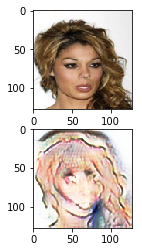

In [80]:
%matplotlib inline
f, (ax1, ax2) = plt.subplots(2, 1)
axes = [ax1, ax2]
check_discriminator(model, train_dataset[5]["A"], train_dataset[5]["B"], axes)

L1 loss:  tensor(0.0774, device='cuda:0', grad_fn=<L1LossBackward>)


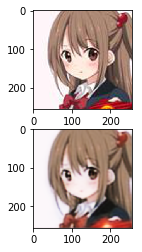

In [24]:
%matplotlib inline
f, (ax1, ax2) = plt.subplots(2, 1)
axes = [ax1, ax2]
check_autoencoder(model, train_dataset[50]["B"], axes)

In [48]:
torch.randn(1, 2, 3)

tensor([[[-0.3672,  0.4688, -2.0885],
         [-1.3030, -0.0188,  0.1824]]])